In [1]:
# Preamble - make sure that packages are installed and set up.
# From our previous lab, you should have cartopy, gmt and xarray installed.
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import gdal
from gdal import osr

# Per Sarah's slack message, the easiest way to read and plot a geotiff in python is probably rasterio.
# The following line will install it. The exclamation point at the start of the line tells Python to run this command
try:
    import rasterio
except ImportError:
    # note that the -y means 'yes' - it automatically accepts any prompts to the user.
    !conda install -y rasterio
    import rasterio
try:
    import affine
except ImportError:
    !conda install -y affine
    from affine import Affine

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rasterio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.3.0               |             py_0          16 KB  conda-forge
    click-plugins-1.1.1        |             py_0           9 KB  conda-forge
    cligj-0.5.0                |             py_0           8 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    rasterio-1.1.3             |   py36h900e953_0         8.3 MB  conda-forge
    snuggs-1.4.7               |             py_0           8 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.5 MB

The following NEW packages will be INSTALLED:

  affine             conda-forge/noarch::affine-2.3.0-py_0
  click-plugins      conda

# Lab 4 - Calculating strains from displacements

This week we're going to work with a high-resolution map of displacements that were computed by 3D differencing of two LiDAR datasets. The data comes from before and after the M7 2016 Kumamoto, Japan earthquake. The LiDAR datasets were acquired before and after the Kumamoto earthquake. Hence, the deformation field records the coseismic deformation, plus any additional tectonic or non-tectonic deformation that occurred between the pre-earthquake scan and the post-earthquake scan. We will calculate strains and stresses associated with this deformation.

The data was processed using OpenTopography.org using 3D differencing. 
You can read more about how others have processed and interpreted the data here: [Scott et al. 2018](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JB015581?casa_token=wF5TVyL3wPkAAAAA%3Al3ka-XPWmet8y25a7XhcnWczCS1TcagQffVoWdEejVwpMGUr1PTBAZhdMpGCmN_RYIJcU8a8mjM-fh8-)

Scott, C. P., Arrowsmith, J. R., Nissen, E.,Lajoie, L., Maruyama, T., & Chiba, T.(2018). The M7 2016 Kumamoto, Japan,earthquake: 3-D deformation along thefault and within the damage zoneconstrained from differential lidartopography. Journal of Geophysical Research: Solid Earth, 123, 6138–6155.

You have been provided with several files:
- `dx.tif` contains the x-displacements ($u_x$)
- `dy.tif` contains the y-displacements ($u_y$)
- `dz.tif` contains the x-displacements ($u_z$)
- `rot_*.tif` contain informations about rotations. We are not going to use these but in principle these quantities provide additional information about the deformation field.
- `viz.tin.hs.white.png` contains a hillshade image of the study area, shown below:

<img src="viz.tin.hs.white.png" width=800></img>

In [2]:
def load_geotiff(filename):
    #This is a function to load data from a geotiff file. It returns vectors containing the x and y coordinates
    #Here, the x and y coordinates are given in meters easting and northing in a local coordinate system.
    #For the purposes of this lab, we don't need to worry about the details of the coordinate system.
    #This function assumes that points for which there is no data are assigned the special value -999.0.
    dem = gdal.Open(filename)
    dem_data = dem.ReadAsArray()
    dem_transform = dem.GetGeoTransform()
    dem_projection = dem.GetProjection()
    n_cols = dem.RasterXSize
    n_rows = dem.RasterYSize
    origin_x = dem_transform[0]
    origin_y = dem_transform[3]
    pixel_width = dem_transform[1]
    pixel_height = dem_transform[5]

    x = np.arange(n_cols) * pixel_width + origin_x
    y = np.arange(n_rows) * pixel_height + origin_y
    mask = dem_data == -999.0 # SET NO DATA VALUES TO NAN - CHANGE BEFORE REUSING CODE
    dem_data[mask] = np.nan
    return x,y,dem_data

# exmaple: Load the dx values
x,y,ux = load_geotiff('dx.tif')

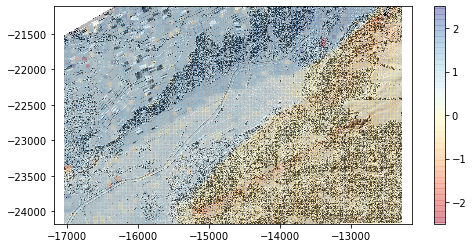

In [3]:
# prepare a fancy picture showing x-displacement overlain on hillshade:
import imageio
hillshade = imageio.imread('viz.tin.hs.white.png')
fig=plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.imshow(hillshade,cmap=plt.get_cmap('Greys'),extent=(x[0],x[-1],y[-1],y[0]),origin='upper')
h = ax.pcolor(x,y,ux,vmin=-2.5,vmax=2.5,cmap=plt.get_cmap('RdYlBu'),alpha=0.25)
plt.colorbar(h)
plt.axis('equal',adjust='box') # make pixels square
plt.show()

**In the image above, you should be able to see that the abrupt change in displacement occurs along the southern boundary of the low-lying plains in the center of the image.**

# Calculate the gradients of displacement
In order to calculate strains, you will need information about the derivatives of displacement. As is always the case, you do not have information about the derivatives of displacement in the vertical direction. However, you can calculate the derivatives of $u_x$, $u_y$ and $u_z$ with respect to $x$ and $y$. Do this now. The most straightforward way to do this is using the built-in NumPy gradent command:
```python
dux_dx,dux_dy = np.gradient(ux,x,y) # dudx and dudy contain derivatives of ux with respect to x and y
```

You could also calculate the gradients yourself using finite difference approximations. For example:
$$\begin{eqnarray}
\frac{\partial u}{\partial x}\bigg|_{i,j} &\approxeq& \frac{u[i,j+1]-u[i,j]}{2\Delta x}\\
\frac{\partial u}{\partial y}\bigg|_{i,j} &\approxeq& \frac{u[i+1,j]-u[i-1,j]}{2\Delta y}
\end{eqnarray}
$$
This is the approach taken in the numpy `gradient` function. $\Delta x$ and $\Delta y$ are the spacing between points in the easting and northing direcions, respectively. Don't forget to check and make sure that you know whether x and y are in increasing or decreasing order (often a problem when dealing with images/DEMs).

You may want to plot/visualize the displacement gradients to see what they look like before moving on.

[[      nan       nan       nan ... -0.981107 -0.48191  -0.378078]
 [      nan       nan       nan ... -0.981107 -0.48191  -0.378078]
 [      nan       nan       nan ... -0.457759 -0.518964 -0.432416]
 ...
 [ 0.673825  0.673825  0.963434 ... -0.464568 -0.414226 -0.432992]
 [ 0.694251  0.694251  0.884428 ... -0.435436 -0.349956 -0.312245]
 [ 0.918975  0.918975  0.859444 ... -0.307709 -0.324684 -0.310906]]
[[            nan             nan             nan ...  3.60995098e-03
   5.91204902e-03  2.03592157e-03]
 [            nan             nan             nan ...  3.60995098e-03
   5.91204902e-03  2.03592157e-03]
 [            nan             nan             nan ... -3.20461765e-03
   2.48460784e-04  1.69701961e-03]
 ...
 [ 0.00000000e+00  2.83930392e-03  3.13482353e-03 ... -3.37696078e-04
   3.09568627e-04 -3.67960784e-04]
 [ 0.00000000e+00  1.86448039e-03  1.62765686e-03 ...  8.62784314e-04
   1.20775490e-03  7.39431373e-04]
 [ 0.00000000e+00 -5.83637255e-04  3.60235294e-04 ...  8.40637

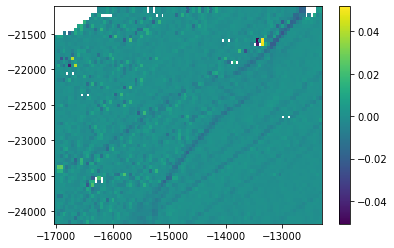

In [4]:
# exx .. d(ux)/dx
# exy .. 0.5*(d(ux))/dy + d(uy)/dx
# eyy .. d(uy)/dy
from matplotlib import pyplot as plt
dux_dy,dux_dx = np.gradient(ux, y, x) # rows are y
print(ux)
print(dux_dx)
plt.pcolormesh(x, y, dux_dx)
plt.colorbar()
plt.show()

# Calculate the strain tensor components

First, think about which strain tensor components you can calculate. In 3D, some of the components will involve $d/dz$ and you cannot calculate these. Calculate the strain tensor components for which you can calculate the displacement gradients.

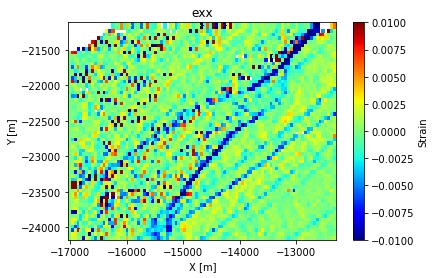

In [5]:
# exx
# exy
# eyy
# eyx = exy

x,y,uy = load_geotiff('dy.tif')
duy_dy,duy_dx = np.gradient(uy, y, x) # rows are y
x,y,uz = load_geotiff('dz.tif')
duz_dy,duz_dx = np.gradient(uz, y, x) # rows are y
exx = dux_dx
exy = 0.5 * (dux_dy + duy_dx)
eyy = dux_dy
plt.pcolormesh(x, y, exx, cmap=plt.get_cmap('jet'), vmin=-.01, vmax=.01)  # plot exx
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.colorbar(label='Strain')
plt.title('exx')
plt.show()

# Now, think about stress-strain relationship.

The surface of the earth is traction-free (no normal or shear tractions are imposed). We call this a 'free surface'.
Mathematically, this requires that: 
$$
\sigma_{33} = 0\\ 
\sigma_{13} = 0\\
\sigma_{23} = 0
$$
If we assume that all of the measured deformation is elastic (not a good assumption - we'll return to this later), what additional constraints can you place on the unknown strain tensor components? Recall the relationship between stresses and strains (Stacey and Davis equation 11.5):
$$
\sigma_{11} = \lambda(e_{11} + e_{22} + e_{33}) + 2\mu e_{11}\\
\sigma_{22} = \lambda(e_{11} + e_{22} + e_{33}) + 2\mu e_{22}\\
\sigma_{33} = \lambda(e_{11} + e_{22} + e_{33}) + 2\mu e_{33}\\
\sigma_{12} = 2\mu e_{12}\\
\sigma_{13} = 2\mu e_{13}\\
\sigma_{23} = 2\mu e_{23}\\
$$

Given this additional information, calculate any of the strain tensor components that you can here. You may need values of the elastic moduli. You can look up common values for the upper crust.

In [6]:
# lambda * (exx + eyy + ezz) + 2 * mu * ezz
E = 3e10  # Young's modulus, Pa
nu = 0.25  # poisson ratio
lbd = E * nu / (1 + nu) / (1 - 2 * nu)  # lame's first coefficinet
mu = lbd * (1 - 2 * nu) / (2 * nu)  # shear modulus
ezz =  - lbd / (lbd + 2 * mu) * (exx + eyy)  # ezz = lambda * (exx + eyy + ezz) + 2mu*ezz

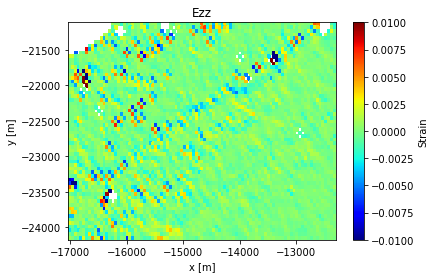

In [7]:
# plot ezz
fig, ax = plt.subplots()
cset = ax.pcolormesh(x, y, ezz, cmap=plt.get_cmap('jet'), vmin=-.01, vmax=.01)  # plot ezz
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ezz')
fig.colorbar(cset, ax=ax, label='Strain')
fig.show()

# Calculate and plot stresses and strains:
Make plots of the elastic stresses and strains. I suggest making a two-panel figure that shows (1) in the first panel a pseudocolor plot of the volumetric stress (or strain) and (2) in the second panel a pseudocolor plot of the square-root of the second deviatoric stress (or strain) invariant $\sqrt{II_{\sigma^D}}$. 

Recall that the deviatoric component of a tensor can be calculated as
$$
A^D_{ij} = A_{ij} - \frac{1}{3}tr(\underline{\underline{A}})\delta_{ij}
$$
The second invariant of a tensor *A* is given by the following expression (it is a scalar quantity that is used to describe the intensity of shear stress or strain).
$$
II_A = A_{11}A_{22} + A_{22}A_{33}+A_{11}A_{33} - A_{12}A_{21} - A_{23}A_{32}-A_{13}A_{31}
$$
Make sure to include a color bar and units for the computed quantities.

You may be interested in making a comparison with Figure 9 in Scott et al. (2018).

**Note: The von Mises yield criterion is one model for material failure - failure is expected when $\sqrt{3 J_2} > \sigma_v$ . Here, $J_2$ is the second deviatoric stress invariant and $\sigma_v$ is the von Mises yield stress, equal to the tensile strength.**

In [8]:
# compute volumetric strain and square-root of the second deviatoric strain invariant
exz = 0
eyz = 0
e_trace = exx + eyy + ezz  # trace of strain
e_dxx = exx - 1.0 / 3 * e_trace
e_dyy = eyy - 1.0 / 3 * e_trace
e_dzz = ezz - 1.0 / 3 * e_trace
e_dxy = exy
e_dxz = exz
e_dyz = eyz
e_second_invariant = e_dxx * e_dyy + e_dyy * e_dzz + e_dxx * e_dzz \
                    - e_dxy * e_dxy - e_dyz * e_dyz - e_dxz * e_dxz  # second deviatoric strain invariant

In [9]:
# compute components of stress
sigmaxx = lbd * (exx + eyy + ezz) + 2 * mu * exx
sigmayy = lbd * (exx + eyy + ezz) + 2 * mu * eyy
sigmazz = 0
sigmaxy = 2 * mu * exy
sigmaxz = 0
sigmayz = 0
sigma_trace = sigmaxx + sigmayy + sigmazz  # compute trace and deviatoric tensor
sigma_dxx = sigmaxx - 1.0 / 3 * sigma_trace
sigma_dyy = sigmayy - 1.0 / 3 * sigma_trace
sigma_dzz = sigmazz - 1.0 / 3 * sigma_trace
sigma_dxy = sigmaxy
sigma_dxz = sigmaxz
sigma_dyz = sigmayz
sigma_second_invariant = sigma_dxx * sigma_dyy + sigma_dyy * sigma_dzz + \
                        sigma_dxx * sigma_dzz - sigma_dxy * sigma_dxy - \
                        sigma_dyz * sigma_dyz - sigma_dxz * sigma_dxz

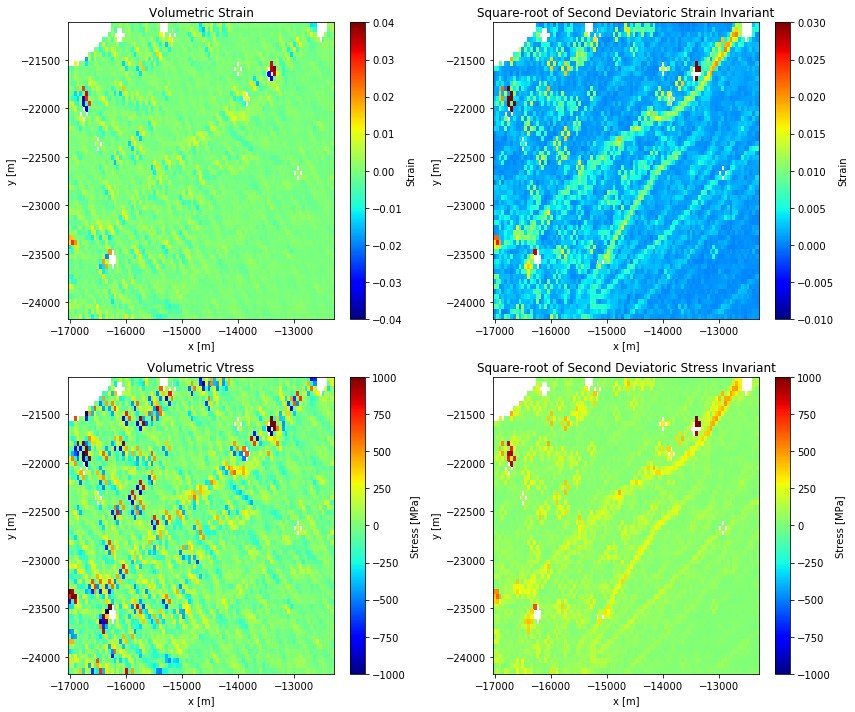

In [10]:
# plot volumetric strain and square-root of the second deviatoric strain invariant,
# volumetric stress and square-root of the second deviatoric stress invariant
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
cset00 = axs[0, 0].pcolormesh(x, y, e_trace, cmap=plt.get_cmap('jet'), vmax=0.04, vmin=-0.04)  # plot volumetric strain
axs[0, 0].set_xlabel('x [m]')
axs[0, 0].set_ylabel('y [m]')
axs[0, 0].set_title('Volumetric Strain')
fig.colorbar(cset00, ax=axs[0, 0], label = 'Strain')
cset01 = axs[0, 1].pcolormesh(x, y, np.sqrt(np.abs(e_second_invariant)), cmap=plt.get_cmap('jet'), vmax=0.03, vmin=-0.01)  # plot volumetric strain
axs[0, 1].set_xlabel('x [m]')
axs[0, 1].set_ylabel('y [m]')
axs[0, 1].set_title('Square-root of Second Deviatoric Strain Invariant')
fig.colorbar(cset01, ax=axs[0, 1], label = 'Strain')
cset10 = axs[1, 0].pcolormesh(x, y, sigma_trace/1e6, cmap=plt.get_cmap('jet'), vmax=1.0e3, vmin=-1.0e3)  # plot volumetric stress
axs[1, 0].set_xlabel('x [m]')
axs[1, 0].set_ylabel('y [m]')
axs[1, 0].set_title('Volumetric Vtress')
fig.colorbar(cset10, ax=axs[1, 0], label = 'Stress [MPa]')
cset11 = axs[1, 1].pcolormesh(x, y, np.sqrt(np.abs(sigma_second_invariant))/1e6, cmap=plt.get_cmap('jet'), vmax=1.0e3, vmin=-1.0e3)  # plot square-root of second deviatoric stress invariant
axs[1, 1].set_xlabel('x [m]')
axs[1, 1].set_ylabel('y [m]')
axs[1, 1].set_title('Square-root of Second Deviatoric Stress Invariant')
fig.colorbar(cset11, ax=axs[1, 1], label = 'Stress [MPa]')
fig.tight_layout()
fig.show()

Sorry, I don't think I have the bandwidth to do the bonus this time.

# BONUS: Principal axes
Calculate the orientation of the principal axes of stress and strain. One way to approach this is to loop over all of the points in the domain. At each point, assemble a matrix representing the stress tensor. Find the eigenvalues and eigenvectors (use the built-in routines in numpy/scipy to do this). Make a plot showing the orientation of the principal axes (you will want to make sure to use one color for the axis of maximum tension and another for the axis of minimum tension).